## FORCAST Grism Spectra: Basic Line Analysis
-------------------
**Aim**: Basic line fluxes and line fitting of grism data. <br />
**Data**: Level 3 grism data of the Saturn Nebula (G111) <br />
**Tools**: astropy, specutils <br />
**Instrument**: FORCAST<br />
**Documentation**: [FORCAST data handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf)

## Goals
* Load and clean grism data
* Fit the continuum
* Measure the line fluxes
* Fit a spectral lines with a 1D Guassian


## Introduction

This recipe provides an overview and sample code (in Python) for some simple line analysis tasks using FORCAST grism observations.  We recommend that the user reviews the first FORCAST Grism Recipe ([FORCAST Grism Recipe: Basic Inspection and Assessment](FORCAST-Grism_Inspection-1.ipynb)) before proceeding with this slightly more advanced tutorial.  

Raw FORCAST data suffers from several instrumental artifacts.  Nearly all of the artifacts are removed or corrected by the FORCAST pipeline, including: bad pixels; the Droop effect; non-linear pixel response; and the “jailbar” effect.  In addition, the grism pipeline extracts the one-dimensional spectra, applies both wavelength and flux calibration, and corrects for telluric absorption.   For point sources, an "optimal extraction" algorithm is used, while for extended (non-pointlike) sources, a standard summation over a manually defined aperture is used.  See the [FORCAST GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf) for details regarding the artifacts, pipeline algorithms, and the flux-calibration process.  

In this recipe we show the user how to do some minor "cleaning" of the LEVEL_3 data and then some basic emission line analysis including continuum fitting and subtraction, line flux measurement, and simple line fitting. 


There are a handful of relatively mature spectral line analysis in python, including linetools and pyspeckit.  For this recipe/example, we are using specutils since this seems to be the most general package.  

## Imports

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models
from astropy.table import Table,QTable,Column
from astropy import constants as const
from astropy import units as u
from astropy.visualization import quantity_support

from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum

%matplotlib inline
quantity_support() ;

## Ingredients

1. Level 3 (flux calibrated) FORCAST grism data (either CAL or CMB files) from the Infrared Science Archive ([ISRA](https://irsa.ipac.caltech.edu/Missions/sofia.html)).
2.  Sample Data (if desired):  In this example we will be using observations of the PN NGC 7009.  
    - Level 3 data can be obtained from the ISRA using the following search criteria:
        - Coordinates or Object Name = NGC 7009
        - Radius = 100 arcseconds
        - Mission ID = "2017-08-07_FO_F428"
        - AOR ID = 05_0063_7
        - Instrument = FORCAST
        - Processing State = Level 3
    - Download all data and save to local desktop. 
    - **You can download the example data directly [here](https://zenodo.org/record/5706312/files/FORCAST-Grism_Inspection-example-data.zip?download=1)**.
    
    - For this example we will be using the following files:  
        - F0428_FO_GRI_0500637_FORG111_CAL_0177-0196.fits
        - F0428_FO_GRI_0500638_FORG227_CMB_0197-0215.fits
    - For convenience, we recommend saving both files in a folder called "forcast-sample-data" in the same directory as this Python Notebook.
3. [FORCAST GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf) for reference (latest version can be found on the [SOFIA Data Products and Archives page](https://www.sofia.usra.edu/science/proposing-and-observing/data-products/data-resources))
4. Download and install specutils from the [AstroPy Affiliated Packages](http://www.astropy.org/affiliated/index.html) page.

## Cleaning the Data

First we'll load the calibrated data for a single grism observation (G111 in this example) and take a look at the spectrum.

/Users/srgoldma/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


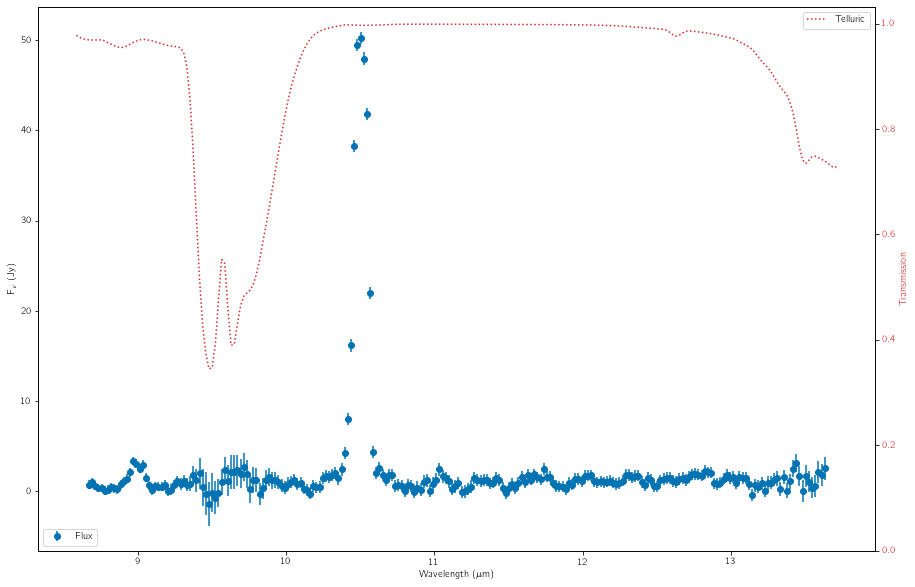

In [2]:
#Define a function for loading fits data into table structure,
#keeping the FITS data for later use if needed.
def loadFORCASTGrismData(filename):
    #Now open fits file for the sample data...
    data_fits = fits.open(filename)

    #... read the data portion of the file into a separate array:
    data_tmp = data_fits[0].data

    #... load into table for convenience
    data_table = Table([data_tmp[0],data_tmp[1],data_tmp[2],data_tmp[3],data_tmp[4]], 
                  names=('wavelength', 'flux', 'error', 'telluric', 'response'), masked = True,
                  meta={'name': 'Data Table'})

    #and assign units.
    data_table['wavelength'].unit = 'micron'
    data_table['flux'].unit = 'Jy'
    data_table['error'].unit = 'Jy'
    data_table['response'].unit = 'Jy/s'
    
    #...and mask out NaNs in flux.
    data_table['flux'].mask = np.isnan(data_table['flux'])
    
    return data_fits,data_table


#Calibrated data file on local disk:
calfile = 'F0428_FO_GRI_0500637_FORG111_CAL_0177-0196.fits'

#Load fits data and tabular data...
g111_fits, g111_tab=loadFORCASTGrismData(calfile)

#And plot flux and telluric spectra
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g111_tab['wavelength'],g111_tab['flux'],yerr=g111_tab['error'],fmt='o',label="Flux")
ax1.legend(loc="lower left")

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g111_tab['wavelength'],g111_tab['telluric'], color=color, linestyle=':',label="Telluric")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=0.0)
ax2.legend();

This G111 spectrum appears to contain two strong emission lines:  one at ~9.0$\mu$m (ArIII) and a very strong one at ~10.5$\mu$m (SIV).  A nice table of line wavelengths and strengths can be found on the [MPE website](http://www.mpe.mpg.de/ir/ISO/linelists/).  There are two main issues we need to "clean" before proceeding with line analysis:  NaN values and noisy data due to deep telluric features.  We'll define a function for this that creates a mask and then uses it to create a new "clean"-ed table of wavelength, flux, and error (leaving the telluric and response sprectra behind).  We already masked the NaNs when we read the FITS file and created the data tables, so we just need to add the telluric regions to the mask. 

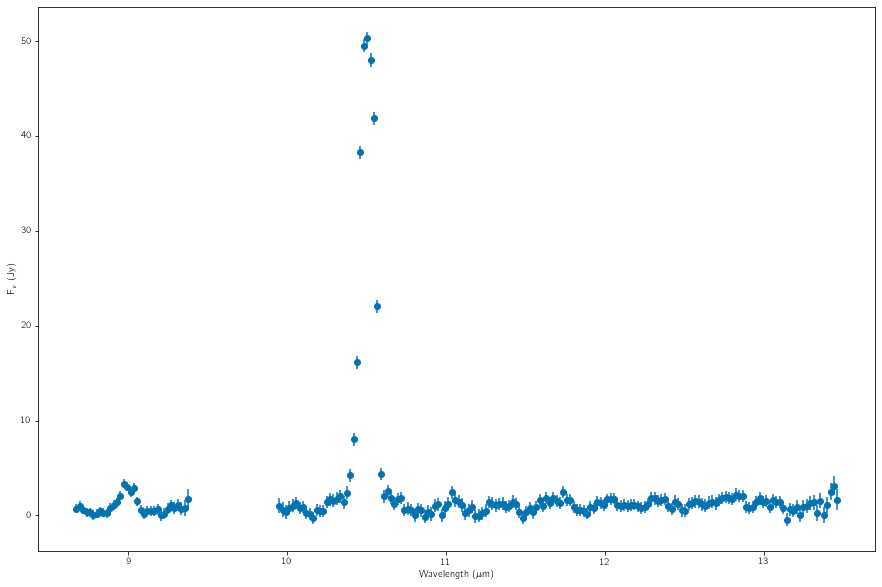

In [3]:
#Define a "clean"-ing function, that takes a FORCAST data table and telluric threshold as inputs:

def cleanFORCASTGrismData(in_table,tell_thresh):
    #Now define mask (= True) for telluric transmission and add to the exisitng mask.
    in_table['flux'].mask  = in_table['flux'].mask | (in_table['telluric'] < tell_thresh)

    #and apply NOT(Mask) to the wavelength, flux, and error arrays,
    #to pull out new "clean" arrays
    fc = in_table['flux'][~in_table['flux'].mask]
    wc = in_table['wavelength'][~in_table['flux'].mask]
    fc_err = in_table['error'][~in_table['flux'].mask]

    #and return a new table with cleaned arrays
    #Need to use QTable here to support specutils later.
    return QTable([wc,fc,fc_err], 
                  names=('wavelength', 'flux', 'error'), masked = True,
                  meta={'name': 'Cleaned Spectrum'})


#and now execute on our data for G111 with a telluric threshold of 0.75
g111_clean = cleanFORCASTGrismData(g111_tab,0.75)

#And plot flux and errors
plt.figure(figsize=(15,10))
plt.errorbar(g111_clean['wavelength'].value,g111_clean['flux'].value,yerr=g111_clean['error'].value,fmt='o',label="Flux")
#plt.legend(loc="lower left")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)');


Now that the spectrum is cleaned, we are ready to begin some simple line analysis.

## Fitting the Continuum Across the Grism

Our first analysis task is to fit the continuum across the grism.  In this step, the hard part is identifying all the sections of "line-free" continuum.  There are many ways to do this automatically, but in this example we will simply estimate the continuum regions by eye. The easiest way to bookkeep this is to identify all the regions with lines first, then logically invert those regions to extract the continuum.  In the G111 case above, we have two lines:  one at ~9.0 $\mu$m and another stronger one at ~10.5 $\mu$m.  So lets define our line regions as:
- 8.88 -- 9.15 $\mu$m
- 10.25 -- 10.75 $\mu$m

In [4]:
#As usual, lets define a function that takes a list of line regions and extracts everything external to 
#those regions as continuum:
def createContinuumSpectrum(in_table,line_regions):
    wave = in_table['wavelength']
    flux = in_table['flux']
    err = in_table['error']
    
    #initialize the continuum mask, where T corresponds to "is Continuum".
    cont_mask = 1.0*u.um < wave  #initialize to FALSE
    
    #for each line region...
    for x in line_regions:
        #...update mask value to TRUE for all points *outside* of that region
        cont_mask = cont_mask & ~((x[0]<wave) & (x[1]>wave))

    return  QTable([wave[cont_mask],flux[cont_mask],err[cont_mask]], 
                  names=('wavelength', 'flux', 'error'), masked = True,
                  meta={'name': 'Continuum Spectrum'})



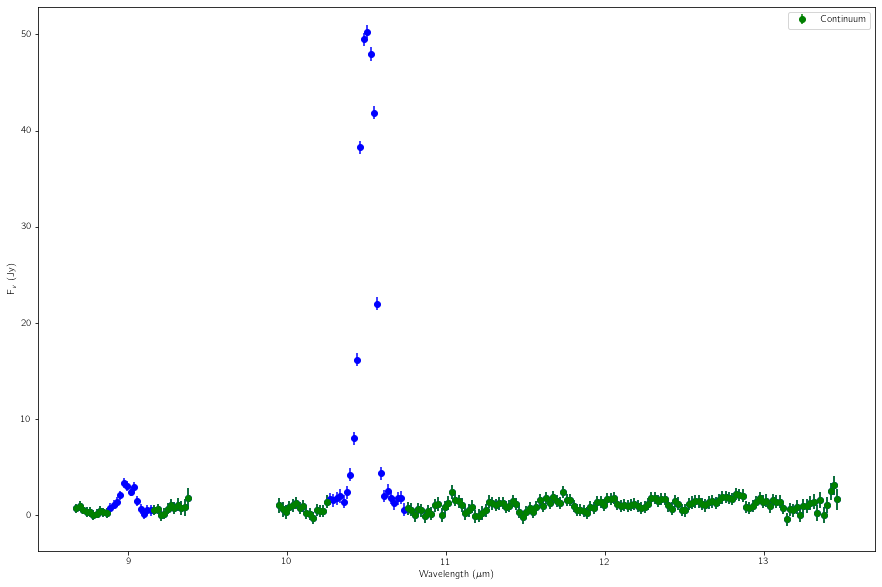

In [5]:
#now try it out with our G111 data
#first define the line regions...
g111_line_regions = [[8.88*u.um,9.15*u.um], 
                [10.25*u.um,10.75*u.um]]

g111_cont = createContinuumSpectrum(g111_clean,g111_line_regions)

#And plot flux and errors with continuum in green
plt.figure(figsize=(15,10))
plt.errorbar(g111_clean['wavelength'].value,g111_clean['flux'].value,yerr=g111_clean['error'].value,fmt='o',color='b')
plt.errorbar(g111_cont['wavelength'],g111_cont['flux'],yerr=g111_cont['error'],fmt='o',color='g',label='Continuum')
plt.legend()
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)');

Now that we have identified the continuum (plotted in green above), we can use specutils to fit it.  specutils utilizes the models and fitters that are part of the astropy.modeling package, so we'll need to load those too.  In the end we'll save the fitted continuum back in the cleaned data table. 

In [6]:
#define a function to fit the continuum; will need to take QTable object as input
#to support the specutils functions.  
def fitContinuum(data,cont):
    #read the wavelength and flux arrays for convenience
    wave = data['wavelength']
    flux = data['flux']
    wave_c = cont['wavelength']
    flux_c = cont['flux']
    
    #Now load arrays into a Spectrum1D objects for further analysis:
    #we'll need one for both the cleaned data and our continuum data:
    spec=Spectrum1D(spectral_axis=wave,flux=flux)
    cont_spec=Spectrum1D(spectral_axis=wave_c,flux=flux_c)

    #use a 2nd order Chebyshev1D -- see astropy.modeling for more info on using models.
    cont_model=models.Chebyshev1D(2, c0=0., c1=0., c2=0.)


    #Now fit continuum across the grism using fit_generic_continuum
    #which takes a continuum Spect1D object as input with optional model (which we defined above).
    cont_fit=fit_generic_continuum(cont_spec, model=cont_model)

    #and calculate fitted flux values for *full* cleaned spectrum    
    data['cont']=cont_fit(spec.spectral_axis)
    
    #Add the continuum fit data to the QTable object.
    return data

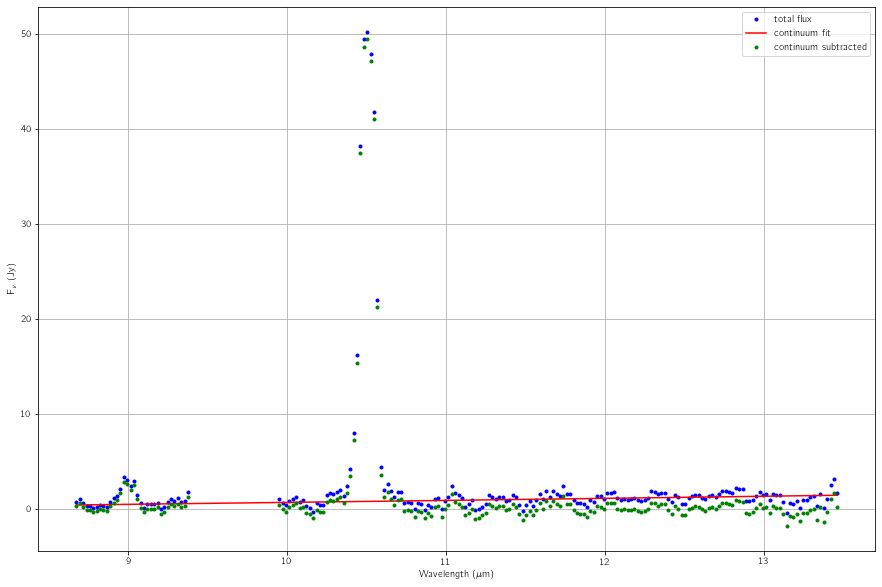

In [7]:
#now try it out with our G111 data:
fitContinuum(g111_clean,g111_cont)

#and plot model and continuum subtracted flux
plt.figure(figsize=(15,10))
plt.plot(g111_clean['wavelength'].value,g111_clean['flux'].value,'b.',label = "total flux")
plt.plot(g111_clean['wavelength'].value,g111_clean['cont'].value,color="r",label='continuum fit')
plt.plot(g111_clean['wavelength'].value,g111_clean['flux'].value-g111_clean['cont'].value,'g.',label='continuum subtracted')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend()
plt.grid()


USER EXERCISE:  Fit the continuum to the NGC7009 G227 data (see ingredients above), which is slightly larger and more sloped than the G111 continuum.

## Measuring Line Flux

The specutils package comes with a number of convenient tools for basic line analysis. This recipe focuses on emission lines, but generally speaking the tools can be used with absorption lines as well.  Our first task will be to measure the line flux from the line of interest, in this case, the strong SIV line at 10.5 $\mu$m.  

We will first load our "clean"-ed continuum-subtracted flux data (along with the errors) into a specutils Spec1D structure and then isolate the line:

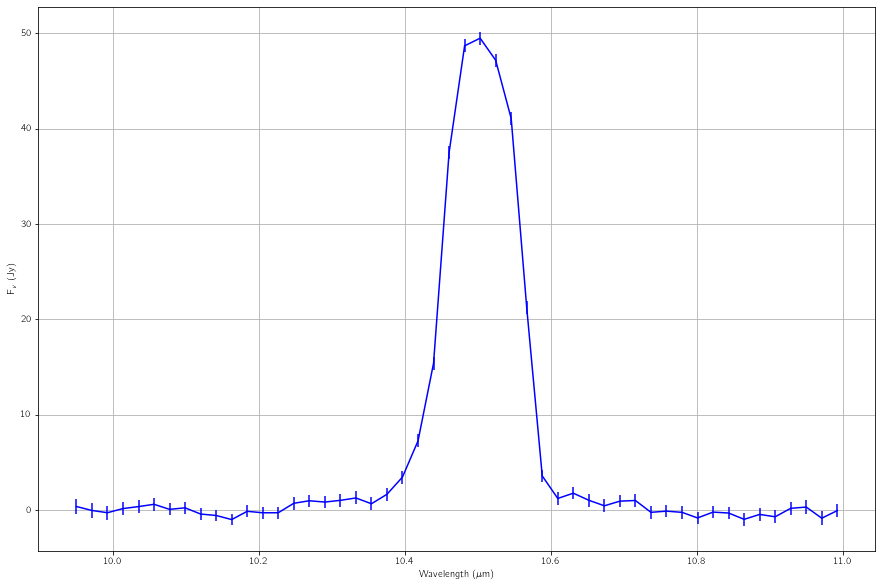

In [8]:
from specutils.manipulation import extract_region

#First read wavelength, flux, and continuum from our cleaned data table:
wave = g111_clean['wavelength']
flux = g111_clean['flux'] - g111_clean['cont']  #use continuum subtracted flux
err = g111_clean['error']

#Now load into Spect1D object:
spec = Spectrum1D(spectral_axis=wave,flux=flux)
err_spec = Spectrum1D(spectral_axis=wave,flux=err)

#Now define sub region for the 10.5 micron line, just eye-balling from the plot above.
lines_sr = SpectralRegion(9.5*u.um, 11.*u.um)

#And extract those regions for separate analysis.
#Extract_region takes a Spect1D and SpectralRegion objects as inputs and returns
#a *list* of Spect1D objects, one per region.  
lines = extract_region(spec, lines_sr)
line_errs = extract_region(err_spec, lines_sr)


#Plot resulting region surrounding our line:
plt.figure(figsize=(15,10))
plt.errorbar(lines.spectral_axis,lines.flux,yerr=line_errs.flux, 
             color='b',label='data')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.grid()

Now compute the line flux using the built-in function in specutils, which simply integrates under the data.  For convenience, we'll convert the Spec1D objects to frequency space to make the unit conversions easier.  Since line_flux is essentially just doing an integration over frequency across the *region*, we can estimate the 1-$\sigma$ uncertainty of the line flux by simply adding the flux errors over the region in quadrature and multiplying by the wavelength step.

In [9]:
#convert spec1D objects to frequency space
#and reverse the arrays b/c apparently specutils expects spectral_axis to be increasing.
tmp=lines.spectral_axis
nu=tmp.to(u.THz,equivalencies=u.spectral())
lines_nu = Spectrum1D(spectral_axis=nu[::-1],flux=lines.flux[::-1])

#And now use the line_flux function to get total line fluxes for the line.  
#line_flux takes a *continuum subtracted* Spectrum1D object with optional spectral region, 
#if the user wants to integrate over a smaller region.
from specutils.analysis import line_flux

#print lineflux for each line region and convert to W/m^2
print(lines_nu)  #Print some info about the line region.
print('Line Flux:')
print(line_flux(lines_nu))
print(line_flux(lines_nu).to(u.W * u.m**-2))
    
    
#calculate the errors 
errs = line_errs.flux
quad = np.sqrt(np.sum(errs**2))
    
#multiply by the step size in nu, delta_nu.
#Here I'm simply calculating the average delta_nu across the region:  (nu_max - nu_min)/(N - 1)
#Where N is the number of samples (points).
nu = lines_nu.spectral_axis
del_nu = (np.max(nu) - np.min(nu))/(len(nu) - 1)
line_flux_err = quad * del_nu
print('Error:')
print(line_flux_err)
print(line_flux_err.to(u.W * u.m**-2))
print('SNR:')
print(line_flux(lines_nu)/line_flux_err)
print('----------------------------')



Spectrum1D (length=50)
flux:             [ -0.060154 Jy, ..., 0.36707 Jy ],  mean=5.6485 Jy
spectral axis:    [ 27.274 THz, ..., 30.132 THz ],  mean=28.656 THz
Line Flux:
16.355252712734014 Jy THz
1.6355252712734015e-13 W / m2
Error:
0.2786296592121553 Jy THz
2.7862965921215532e-15 W / m2
SNR:
58.69889357428647
----------------------------


USER EXERCISE:  Measure the line flux and SNR for the ArIII line at 9.0 $\mu$m.  

## Line Fitting

Lastly, specutils provides a nice set of tools for some basic line fitting.  Any of the models available in the astropy modelling package can be used.  The default fitter is a Levenberg-Marquardt algorithm for least squares (LevMarLSQFitter) although it appears other fitters could be used as well.  Evaluating model parameter uncertainties is left to the user.  NOTE:  Since the grism resolution is R~100 or so, only sources with a significant amount of high velocity emission (>1000 km/s) will really benefit from line-fitting.   

First load the data into the specutils Spec1D objects and extract the line region:

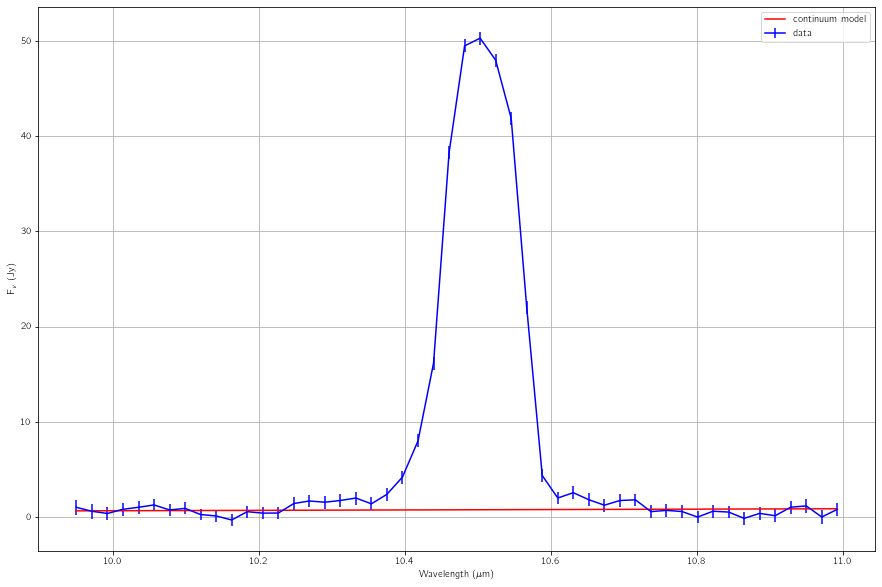

In [10]:
#First read wavelength, flux, and continuum from our cleaned data table:
wave = g111_clean['wavelength']
flux = g111_clean['flux']   #observed flux
err = g111_clean['error']   #errors
cont = g111_clean['cont']  #continuum model

#Now load into Spect1D objects:
spec_obs = Spectrum1D(spectral_axis=wave,flux=flux)
spec_cont = Spectrum1D(spectral_axis=wave,flux=cont)
spec_errs = Spectrum1D(spectral_axis=wave,flux=err)
spec_cs = Spectrum1D(spectral_axis=wave,flux=(flux-cont))  #we'll need continuum subtracted flux in the fitting step.

#Now define sub region for the line at 10.5 micron
line_sr = SpectralRegion(9.5*u.um, 11.*u.um)

#And extract that region for separate analysis.
#Extract_region takes a Spect1D and SpectralRegion objects as inputs and returns
line_obs = extract_region(spec_obs, line_sr)
line_cont = extract_region(spec_cont, line_sr)
line_err = extract_region(spec_errs, line_sr)
line_cs = extract_region(spec_cs, line_sr)   #continuum subtracted 


#Plot total flux and continuum model:
plt.figure(figsize=(15,10))
plt.errorbar(line_obs.spectral_axis,line_obs.flux,
             yerr=line_err.flux,color='b',label='data')
plt.plot(line_cont.spectral_axis,line_cont.flux,label='continuum model',color='red')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.grid()
plt.legend();

Now we'll load the fitting functions and run the fitter; which is only a few lines of code.  Note that a number of profile models are available in the astropy modelling package.  Here we'll use a simple 1D Gaussian:

In [11]:
from specutils.fitting import fit_lines, estimate_line_parameters

#First generate an initial Gaussian profile model with estimates generated from the data.
g_est = estimate_line_parameters(line_cs, models.Gaussian1D())

#Numerous other models (e.g. Voigt, Lorentzian, etc...) are available in the 
#astropy modelling package, which can be specified in the estimate_line_parameters call:
#g_est = estimate_line_parameters(line_cs, models.Voigt1D())
#g_est = estimate_line_parameters(line_cs, models.Lorentz1D())


#Regardless of what model is used, the fitting routine is the same.  
#fit_lines takes a Spect1D object and initial model profile as inputs. 
g_fit = fit_lines(line_cs, g_est)

print(g_fit)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude           mean               stddev      
           Jy             micron              micron      
    --------------- ------------------ -------------------
    53.866258857508 10.503897458720795 0.04462759099997495


Next we'll evaluate the model fluxes at each wavelength and add to the continuum model so we can compare the full model to the observed flux:  

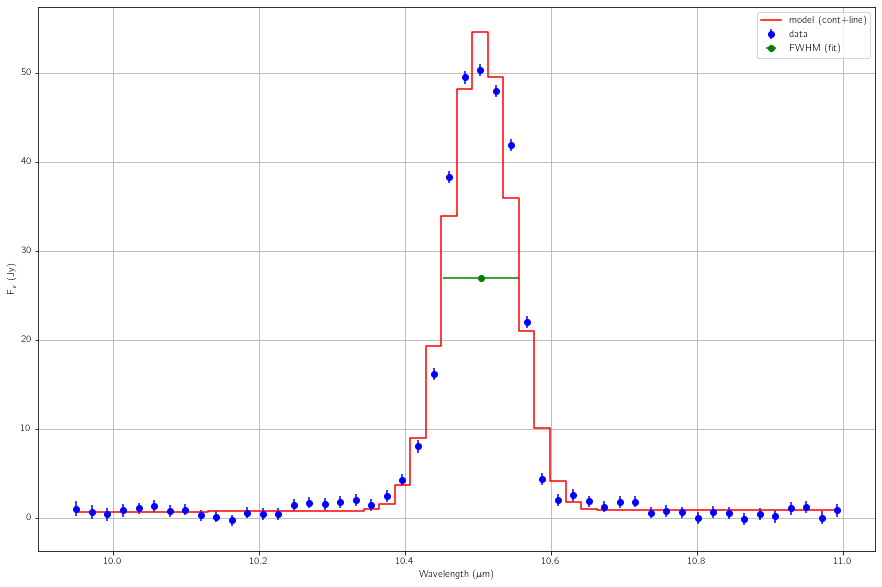

In [12]:
#Calculate the model line flux and add to continuum model to generate full model:
model = g_fit(line_cs.spectral_axis) + line_cont.flux

#And calculate fit parameters for display
wave_cent=[g_fit.mean.value]
hm=[g_fit.amplitude.value / 2.0]
hwhm=[2.355*g_fit.stddev.value / 2.0]

#COmpare full model to observed flux
plt.figure(figsize=(15,10))
plt.errorbar(line_obs.spectral_axis,line_obs.flux,yerr=line_err.flux,
             fmt='o',color='b',label='data')
plt.step(line_obs.spectral_axis,model,label='model (cont+line)',color='red',where='mid')
#And overplot fitted wavelength and FWHM:
plt.errorbar(wave_cent,hm,xerr=hwhm, fmt='o',color='g', label='FWHM (fit)')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.grid()
plt.legend();

A sigma of 0.045 $\mu$m corresponds to a FWHM of 0.106 $\mu$m and an R = v / $\Delta$v of about 100, which is close to the R = 130 limit for the G111 grism.  The line is either marginally resolved, or the image quality for this particular observation was not quite good enough to achieve the best possible resolution.  

We can evaluate the goodness of fit by examining the residuals and calculating the chi-squared and reduced chi-squared statistics.  For the degrees of freedom, remember that we used a 2nd order Chebyshev for our continuum, so we have *6* constraints for the full continuum and line model.

Chi Squared:
302.98749794155054
Reduced Chi Squared:
6.886079498671603


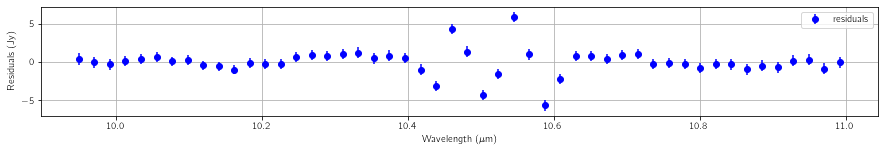

In [13]:
#Now calculate residuals:
res = line_obs.flux - model

#...and plot them.
plt.figure(figsize=(15,2))
plt.errorbar(line_obs.spectral_axis,res,yerr=line_err.flux,fmt='o',color='b',label='residuals')
#plt.plot(x.spectral_axis,line_fit,label='line fit',color='red')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Residuals (Jy)')
plt.grid()
plt.legend()

#Report the chi**2 statitic (for comparison to other model fits), and the reduced chi-squared:
c = 6  #nubmer of constraints (parameters) on our continuum + line model.
chisq=np.sum((res**2)/(line_err.flux)**2)
chisq_nu=chisq/(len(line_obs.flux)-c)
print('Chi Squared:')
print(chisq)
print('Reduced Chi Squared:')
print(chisq_nu)




While a 1D Gaussian may provide a good estimate of the line centroid and width, it is not a terribly good fit to the observed data.  The Voigt profile does not fit very well either:  the residuals and chi-squared statistics are nearly identical to those for the Gaussian profile.  Detailed modelling of the FORCAST grism line profile is still a work in progress.  

USER EXERCISE:  Try fitting the SIV line with Voigt and Lorentzian profiles and comapre the results with the Gaussian case.

USER EXERCISE:  Find the centroid and FWHM for the ArIII line at 9.9 $\mu$m.  